In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(font_scale=1.5)
from tqdm import tqdm

from qiskit import QuantumCircuit, Aer
from qiskit.algorithms import VQE
from qiskit.opflow import X, Z, I, Y, AerPauliExpectation, PauliSumOp
from qiskit.circuit import Parameter
from qiskit.algorithms.optimizers import ADAM

from src.utils import write_to_csv
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.providers.ibmq import least_busy
from qiskit.utils import QuantumInstance


In [2]:
def prepare_state():
    theta = Parameter('theta')
    phi = Parameter('phi')
    QC = QuantumCircuit(1)
    QC.rx(2*(theta-np.pi/2),0)
    QC.ry(2*(phi-np.pi/2),0)
    return QC

def Hamiltonian(lmb):
    E1 = 0
    E2 = 4
    V11 = 3
    V22 = -3
    V12 = 0.2
    V21 = 0.2

    eps = (E1 + E2) / 2
    omega = (E1 - E2) / 2
    c = (V11 + V22) / 2
    omega_z = (V11 - V22) / 2
    omega_x = V12

    # H = eps * I + omega * Z + lmb * (c * I + omega_z * Z + omega_x * X)    
    H = PauliSumOp.from_list([('I', eps + lmb*c), ('Z', omega + lmb*omega_z), 
                              ('X', lmb*omega_x)])

    return H

In [17]:
from qiskit import IBMQ
IBMQ.save_account('cf601c2a41f6b0f0fe8030c8a8c30fd4d5d9d3a4c04f3d4bb070ff7fa4a02de73998a1c22b3db1e211d536e8a02158464d27e78082220cf557267830887dcb07')
# IBMQ.load_account()
provider = QiskitRuntimeService(channel='ibm_quantum')

In [18]:
provider = IBMQ.load_account()

In [31]:
print(provider.backends())

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_jakarta') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibm_lagos') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibm_nairobi') from I

In [40]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import QuantumCircuit, Aer
from qiskit.algorithms import VQE
from qiskit.opflow import X, Z, I, Y, AerPauliExpectation, PauliSumOp
from qiskit.circuit import Parameter
from qiskit.algorithms.optimizers import ADAM

from src.utils import write_to_csv
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.providers.ibmq import least_busy
from qiskit.utils import QuantumInstance


def prepare_state():
    theta = Parameter('theta')
    phi = Parameter('phi')
    QC = QuantumCircuit(1)
    QC.rx(2*(theta-np.pi/2),0)
    QC.ry(2*(phi-np.pi/2),0)
    return QC

def Hamiltonian(lmb):
    E1 = 0
    E2 = 4
    V11 = 3
    V22 = -3
    V12 = 0.2
    V21 = 0.2

    eps = (E1 + E2) / 2
    omega = (E1 - E2) / 2
    c = (V11 + V22) / 2
    omega_z = (V11 - V22) / 2
    omega_x = V12

    # H = eps * I + omega * Z + lmb * (c * I + omega_z * Z + omega_x * X)    
    H = PauliSumOp.from_list([('I', eps + lmb*c), ('Z', omega + lmb*omega_z), 
                              ('X', lmb*omega_x)])

    return H

# backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 4 and 
#                                                      not x.configuration().simulator and x.status().operational==True))

adam = ADAM(maxiter=10_000)

# options = {
# 	'backend_name': backend.name(), # string (required)
# }
options = {
	'backend_name': 'ibmq_qasm_simulator'
}

print(f"Running on {options['backend_name']}")

for index, lmb in enumerate(np.arange(0, 1, 0.1)):
	H = Hamiltonian(lmb)
	runtime_inputs = {
		# A parameterized quantum circuit preparing
		# the ansatz wavefunction for the
		# VQE. It is assumed that
		# all qubits are initially in
		# the 0 state.
		'ansatz': prepare_state(), # object (required)

		# Initial parameters of the ansatz.
		# Can be an array or
		# the string ``'random'`` to choose
		# random initial parameters.
		'initial_parameters': 'random', # [array,string] (required)

		# The Hamiltonian whose smallest eigenvalue
		# we're trying to find. Should
		# be PauliSumOp
		'operator': H, # object (required)

		# The classical optimizer used in
		# to update the parameters in
		# each iteration. Can be either
		# any of Qiskit's Optimizer classes.
		# If a dictionary, only SPSA
		# and QN-SPSA are supported and
		# the dictionary must specify the
		# name and options of the
		# optimizer, e.g. ``{'name': 'SPSA', 'maxiter':
		# 100}``.
		'optimizer': adam, # object (required)

		# A list or dict (with
		# strings as keys) of operators
		# of type PauliSumOp to be
		# evaluated at the final, optimized
		# state.
		'aux_operators': None, # array

		# Initial position of virtual qubits
		# on the physical qubits of
		# the quantum device. Default is
		# None.
		'initial_layout': None, # [null,array,object]

		# The maximum number of parameter
		# sets that can be evaluated
		# at once. Defaults to the
		# minimum of 2 times the
		# number of parameters, or 1000.
		# 'max_evals_grouped': None, # integer

		# Whether to apply measurement error
		# mitigation in form of a
		# complete measurement fitter to the
		# measurements. Defaults to False.
		# 'measurement_error_mitigation': False, # boolean

		# The number of shots used
		# for each circuit evaluation. Defaults
		# to 1024.
		'shots': 1024 # integer
	}

	service = QiskitRuntimeService(
		channel='ibm_quantum'
	)

	job = service.run(
		program_id='vqe',
		options=options,
		inputs=runtime_inputs,
		instance='ibm-q/open/main'
	)

	# Job id
	print(job.job_id)
	# See job status
	print(job.status())


	# Get results
	result = job.result()
	print(lmb, result['optimal_value'])

Running on ibmq_qasm_simulator


C:\Users\augus\AppData\Local\Temp\ipykernel_9028\2667878923.py:125: DeprecationWarning: The 'instance' keyword arguments are deprecated as of qiskit-ibm-runtime 0.7 and will be removed no sooner than 3 months after the release date. Please specify "instance" inside "options".
  job = service.run(


<bound method JobV1.job_id of <RuntimeJob('ch55v9o5ngm0qhf1v2g0', 'vqe')>>
JobStatus.RUNNING


In [36]:
def get_energy_qiskit(experiment, n_points):
    if experiment == 'simulate':
        instance = Aer.get_backend('qasm_simulator')
        filename = 'data/simulate'
        expecation = AerPauliExpectation()
    elif experiment == 'real':
        backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 4 and 
                                                     not x.configuration().simulator and x.status().operational==True))
        # backend = provider.get_backend('ibm_oslo')
        shots = 1024
        instance = QuantumInstance(backend, shots=shots)
        filename = f'data/real_{backend.name}'
        expecation = None
        print(f'Running on backend: {backend.name}')
    else:
        raise ValueError('experiment must be either "simulate" or "real"')

    adam = ADAM(maxiter=1000) #optimizer for VQE
    lmbvalues_qk = range(n_points)
    min_energy_qk = np.zeros(n_points)
    init_point = np.random.uniform(low = 0, high = np.pi, size = 2)
    vqe = VQE(ansatz=prepare_state(), optimizer=adam, initial_point=init_point, 
                    quantum_instance=instance, expectation=expecation)    
    for index, lmb in enumerate(tqdm(lmbvalues_qk)):
        lmb = lmb/n_points
        H = Hamiltonian(lmb)
        result = vqe.compute_minimum_eigenvalue(H)
        min_energy_qk[index] = result.eigenvalue.real
        print(f'lambda: {lmb}, energy: {min_energy_qk[index]}')
    lmbvalues_qk = np.linspace(0, 1 - 1/n_points, n_points)
    write_to_csv(lmbvalues_qk, min_energy_qk, filename=filename, header='lmb,energy')

In [37]:
get_energy_qiskit('simulate', n_points = 10)

 10%|█         | 1/10 [00:09<01:26,  9.59s/it]

lambda: 0.0, energy: 0.2814738664007064


 20%|██        | 2/10 [00:20<01:20, 10.11s/it]

lambda: 0.1, energy: 0.529671931741206


 30%|███       | 3/10 [00:30<01:10, 10.11s/it]

lambda: 0.2, energy: 0.7783703965940102


 40%|████      | 4/10 [00:39<00:58,  9.70s/it]

lambda: 0.3, energy: 1.027779699887063


 50%|█████     | 5/10 [00:49<00:49,  9.95s/it]

lambda: 0.4, energy: 1.278037957813518


 60%|██████    | 6/10 [00:59<00:40, 10.02s/it]

lambda: 0.5, energy: 1.5281954494568468


 70%|███████   | 7/10 [01:09<00:29,  9.90s/it]

lambda: 0.6, energy: 1.7705915536164682


 80%|████████  | 8/10 [01:13<00:15,  7.93s/it]

lambda: 0.7, energy: 1.8279534946599796


 90%|█████████ | 9/10 [01:16<00:06,  6.43s/it]

lambda: 0.8, energy: 1.569186815588405


100%|██████████| 10/10 [01:20<00:00,  8.05s/it]

lambda: 0.9, energy: 1.277227560020167


In [10]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
program_inputs = {'iterations': 1}
options = {"backend_name": "ibm_oslo"}
job = service.run(program_id="hello-world",
                options=options,
                inputs=program_inputs
                )
print(f"job id: {job.job_id()}")
result = job.result()
print(result)

job id: ch4inl85ngm0qheh7olg
Hello, World!


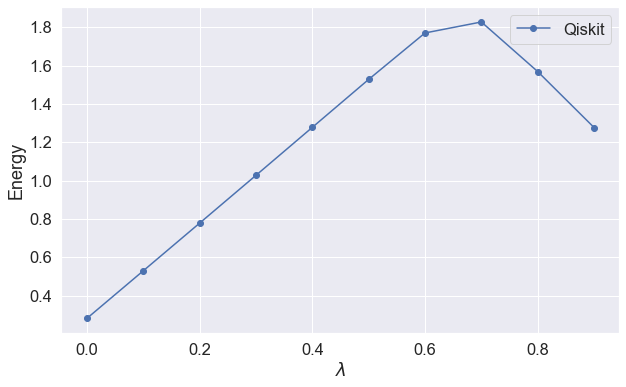

In [38]:
import pandas as pd

df = pd.read_csv('data/simulate.csv')
#rename the columns 
df.columns = ['lmb', 'energy']
fig, axs = plt.subplots(1, 1, figsize=(10, 6))
axs.plot(df['lmb'], df['energy'], label='Qiskit', marker = 'o')
axs.set_xlabel(r'$\lambda$')
axs.set_ylabel('Energy')
axs.legend()
plt.show()

In [13]:

# # Save an IBM Quantum account.
# from qiskit import *

from qiskit import IBMQ
# QiskitRuntimeService.save_account(channel='ibm_quantum', token='cf601c2a41f6b0f0fe8030c8a8c30fd4d5d9d3a4c04f3d4bb070ff7fa4a02de73998a1c22b3db1e211d536e8a02158464d27e78082220cf557267830887dcb07')

# print the least busy backend
print(backend)

<IBMBackend('ibmq_lima')>


In [39]:
# write a program that saves two numpy arrays to a csv file
def write_to_csv(x, y, filename='data.csv', header='x,y'):
    df = pd.DataFrame({'x': x, 'y': y})
    # df.to_csv(filename, header=header, index=False)
    return df

df = write_to_csv(np.linspace(0, 1, 10), np.linspace(0, 1, 10))
df

,x,y
0,0.000000,0.000000
1,0.111111,0.111111
2,0.222222,0.222222
3,0.333333,0.333333
4,0.444444,0.444444
5,0.555556,0.555556
6,0.666667,0.666667
7,0.777778,0.777778
8,0.888889,0.888889
9,1.000000,1.000000
